In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cafa-5-protein-function-prediction/sample_submission.tsv
/kaggle/input/cafa-5-protein-function-prediction/IA.txt
/kaggle/input/cafa-5-protein-function-prediction/Test (Targets)/testsuperset.fasta
/kaggle/input/cafa-5-protein-function-prediction/Test (Targets)/testsuperset-taxon-list.tsv
/kaggle/input/cafa-5-protein-function-prediction/Train/train_terms.tsv
/kaggle/input/cafa-5-protein-function-prediction/Train/train_sequences.fasta
/kaggle/input/cafa-5-protein-function-prediction/Train/train_taxonomy.tsv
/kaggle/input/cafa-5-protein-function-prediction/Train/go-basic.obo
/kaggle/input/protbert-embeddings-for-cafa5/train_ids.npy
/kaggle/input/protbert-embeddings-for-cafa5/train_embeddings.npy
/kaggle/input/protbert-embeddings-for-cafa5/test_ids.npy
/kaggle/input/protbert-embeddings-for-cafa5/test_embeddings.npy
/kaggle/input/t5embeds/train_ids.npy
/kaggle/input/t5embeds/test_embeds.npy
/kaggle/input/t5embeds/train_embeds.npy
/kaggle/input/t5embeds/test_ids.npy
/kaggle/inpu

## Preparing ESM2 Embeddings

In [2]:
import os
import gc

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score


import torch
import numpy as np
from Bio import SeqIO
from Bio import Entrez
from scipy.spatial import distance
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from tqdm import tqdm
tqdm.pandas()

#### Loading ESM2 Embeddings


In [3]:
arr = np.load("/kaggle/input/cafa-5-ems-2-embeddings-numpy/train_embeddings.npy")
Ids = np.load("/kaggle/input/cafa-5-ems-2-embeddings-numpy/train_ids.npy")

# Convert the numpy array to a pandas DataFrame
Esm2Emb = pd.DataFrame(arr)
Ids = pd.Series(Ids.squeeze()) 
Esm2Emb.index = Ids

# Display the first 5 rows of the DataFrame
Esm2Emb.head()

,0,1,2,3,4,5,6,7,8,9,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
Q9ZSA8,-0.092291,-0.066284,-0.012262,0.044118,-0.096111,-0.028308,-0.074759,0.100977,0.024241,0.083448,...,0.003669,-0.076738,-0.023574,0.013527,-0.104102,-0.047541,0.043210,-0.160660,0.015920,0.001738
P25353,0.011624,-0.030318,-0.005802,0.029026,0.028326,-0.034560,0.003770,-0.081593,-0.050148,-0.007592,...,0.082000,0.007247,-0.062506,0.095455,-0.063068,-0.010131,0.042478,-0.153411,0.006632,0.001425
A0A2R8YCW8,0.027373,-0.041047,-0.029205,0.028087,-0.012250,-0.066159,0.030800,0.039873,0.000206,0.055686,...,0.083869,0.008130,-0.122658,-0.020470,0.016220,-0.014810,0.069728,-0.051237,-0.010532,0.022564
G3V5N8,0.033766,-0.078889,-0.059741,0.045629,-0.060334,-0.015612,0.059876,-0.038531,-0.001667,0.075625,...,0.029910,-0.010136,-0.007829,0.052135,0.009843,-0.006972,0.037077,-0.103541,0.010925,0.158402
A0A140LFN4,0.011948,-0.002108,-0.084922,0.068762,0.002155,-0.093367,0.114656,0.040136,0.067143,0.073344,...,-0.030091,0.021493,-0.246086,0.030696,-0.050064,0.078881,0.008374,-0.050359,-0.055477,0.020290


#### Loading Training Data


In [4]:
DATA_DIR = '/kaggle/input/cafa-5-protein-function-prediction'
MAX_LABELS = 1500

DATA_DIR

'/kaggle/input/cafa-5-protein-function-prediction'

In [5]:
%%time
train_terms = pd.read_csv("/kaggle/input/cafa-5-protein-function-prediction/Train/train_terms.tsv",sep="\t")
print(train_terms.shape)
display(train_terms.head(2))
term_count = (train_terms['term'].value_counts())
print(term_count)


(5363863, 3)


,EntryID,term,aspect
0,A0A009IHW8,GO:0008152,BPO
1,A0A009IHW8,GO:0034655,BPO


GO:0005575    92912
GO:0008150    92210
GO:0110165    91286
GO:0003674    78637
GO:0005622    70785
              ...  
GO:0031772        1
GO:0042324        1
GO:0031771        1
GO:0051041        1
GO:0102628        1
Name: term, Length: 31466, dtype: int64
CPU times: user 3.62 s, sys: 494 ms, total: 4.12 s
Wall time: 4.9 s


In [6]:
### Load in the protein IDs
T5_train_file = '/kaggle/input/cafa-5-ems-2-embeddings-numpy/train_ids.npy'
T5_train = np.load(T5_train_file)
print("number of UniProt Accession IDs (Ground truth entry ID):", T5_train.shape[0])
print("UniProt Accession IDs look like", T5_train)

n_labels_to_consider = 1499 # We will only use 1499 labels/ functions to predict

print()
labels_to_consider = list(term_count.index[:n_labels_to_consider] )
counts_to_consider = list(term_count[:n_labels_to_consider])

number of UniProt Accession IDs (Ground truth entry ID): 142246
UniProt Accession IDs look like ['Q9ZSA8' 'P25353' 'A0A2R8YCW8' ... 'Q80VK8' 'Q8IS12' 'P0AG74']



#### Create One Hot Encoded Table for Predictions


In [7]:
%%time

### Prepare Y: 
train_size = T5_train.shape[0] # len(X)
Y = np.zeros( (train_size ,n_labels_to_consider) )
print(Y.shape)

T5_train_series = pd.Series(T5_train) # Series: One-dimensional ndarray with axis labels

train_terms_small = train_terms[train_terms['term'].isin(labels_to_consider)] # keep only GOID in training labels 
print(train_terms_small.shape)

for i in range(Y.shape[1]): # iterate over the number of labels to consider
    m = train_terms_small['term'] == labels_to_consider[i] # make boolean series where Label GOID is used in training set
    Y[:,i] = T5_train_series.isin(set(train_terms_small[m]['EntryID'])).astype(float) # convert these to 0&1s
    if (i % 10) == 0: # print out every 10th iteration to see where code is going
        print(i, m.sum()) #m.sum() should look like the values_count we looked at above
Y 

(142246, 1499)
(4420307, 3)
0 92912
10 53193
20 28680
30 19458
40 16657
50 14757
60 12963
70 11013
80 10236
90 9350
100 8475
110 7664
120 7099
130 6522
140 5866
150 5316
160 5084
170 4831
180 4585
190 4383
200 4214
210 4091
220 3788
230 3652
240 3535
250 3358
260 3231
270 3115
280 3047
290 2952
300 2867
310 2806
320 2764
330 2674
340 2580
350 2483
360 2423
370 2387
380 2295
390 2200
400 2158
410 2106
420 2057
430 1944
440 1866
450 1827
460 1775
470 1742
480 1708
490 1645
500 1614
510 1584
520 1553
530 1513
540 1481
550 1451
560 1427
570 1406
580 1361
590 1343
600 1321
610 1302
620 1290
630 1264
640 1238
650 1220
660 1200
670 1186
680 1170
690 1152
700 1145
710 1125
720 1099
730 1085
740 1062
750 1040
760 1024
770 1005
780 982
790 970
800 956
810 946
820 940
830 927
840 913
850 897
860 891
870 875
880 862
890 851
900 841
910 829
920 816
930 810
940 798
950 784
960 768
970 761
980 749
990 737
1000 732
1010 722
1020 710
1030 703
1040 691
1050 680
1060 668
1070 653
1080 645
1090 639
1100 6

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [8]:
Ydf = pd.DataFrame(Y)
Ydf

Ydf.index = T5_train
Ydf

,0,1,2,3,4,5,6,7,8,9,...,1489,1490,1491,1492,1493,1494,1495,1496,1497,1498
Q9ZSA8,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
P25353,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A0A2R8YCW8,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
G3V5N8,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A0A140LFN4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
O81299,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Q55AH8,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Q80VK8,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Q8IS12,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Extract proteins involved with Splicesome function only and its children GO terms

In [9]:
GO_terms = ["GO:0005684", "GO:0071006", "GO:0071007", "GO:0071008", "GO:0000243", "GO:0071021", "GO:0071004", "GO:0071005 "]

train_terms_min = train_terms[train_terms['term'].isin(GO_terms)]
train_terms_min

Prot = train_terms_min['EntryID'].unique()
Prot

Y_min = Ydf.loc[Ydf.index.isin(Prot)]
Y_min

Embed_min = Esm2Emb.loc[Esm2Emb.index.isin(Prot)]
Embed_min

,0,1,2,3,4,5,6,7,8,9,...,1270,1271,1272,1273,1274,1275,1276,1277,1278,1279
O43172,-0.028082,-0.035212,-0.002003,0.032346,-0.164737,0.013853,0.129623,-0.160591,-0.030582,0.061652,...,-0.015752,-0.076246,-0.143733,0.002509,0.034462,-0.032810,-0.044971,-0.183487,-0.006071,0.179693
Q13573,-0.023764,-0.040242,-0.012632,0.009937,0.085875,-0.011976,0.074902,-0.022111,-0.009551,0.065276,...,-0.005745,-0.034911,-0.047134,0.031244,0.053254,-0.045012,-0.031536,-0.070973,0.056006,0.068930
Q9UK45,0.052434,0.000918,0.038448,-0.067726,-0.083684,-0.097941,0.010707,-0.091025,0.001904,0.010159,...,0.063448,-0.057158,-0.018095,-0.012415,-0.002296,-0.000017,0.144635,-0.163548,-0.029198,0.089169
Q99459,0.014125,-0.083548,-0.040823,0.028257,-0.005826,-0.132313,0.175366,-0.168319,-0.021687,0.054832,...,0.012652,-0.050072,-0.128414,-0.028856,0.095887,-0.145857,-0.063715,-0.092437,0.072375,0.168669
Q09909,0.039210,-0.025477,0.041998,0.020834,-0.028143,-0.072982,0.054860,-0.078500,-0.051735,0.035804,...,0.090923,-0.027497,-0.037425,0.007314,0.024585,-0.028574,0.021750,-0.076984,0.053526,0.005532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
O60508,0.028405,-0.064923,-0.055380,0.095982,-0.071239,0.041833,0.201183,-0.145489,-0.042046,0.088634,...,-0.078570,-0.049272,-0.157950,0.001825,0.020391,-0.101608,-0.008902,-0.183596,-0.009273,0.135040
Q15393,-0.033851,0.016553,0.022237,-0.044028,-0.072324,-0.012685,0.094139,-0.116128,-0.033424,0.086188,...,0.081636,0.004879,-0.060604,-0.006102,-0.045936,-0.027043,0.042044,-0.057076,-0.018255,0.183308
Q7RTV0,0.071550,-0.188554,-0.167744,0.131843,-0.157707,-0.084873,0.314558,-0.143464,-0.156828,-0.052593,...,-0.112304,-0.038594,-0.078272,0.118007,0.099993,-0.039617,0.039128,-0.351219,-0.095488,0.340809
Q07508,0.013912,-0.048954,-0.001224,-0.024063,-0.126401,-0.052073,0.046390,-0.078413,0.018976,0.038353,...,0.028119,-0.037408,-0.034854,-0.000509,0.027301,-0.021405,0.088204,-0.100078,0.090529,0.118432


/opt/conda/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/conda/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argume

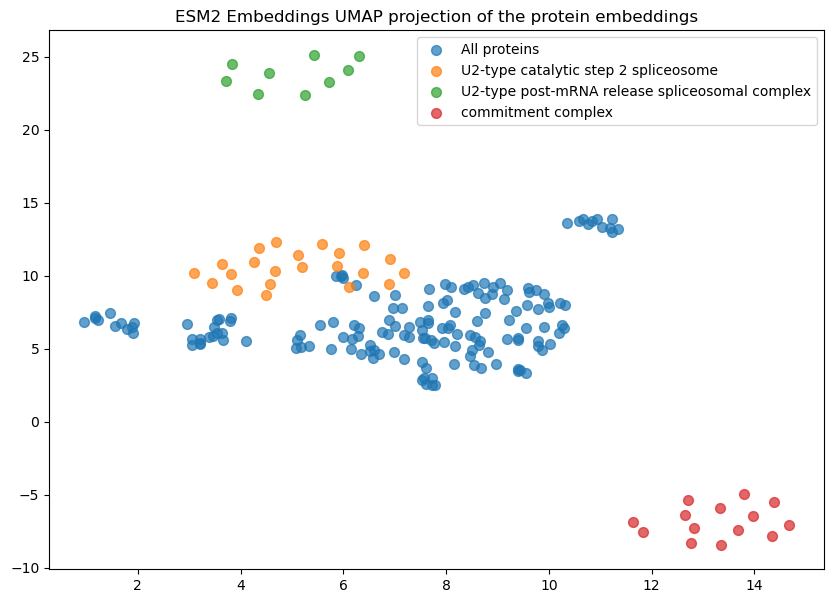

In [10]:
import umap
from sklearn.preprocessing import StandardScaler

# ... previous code goes here ...

# Combine embeddings and apply UMAP
all_embeddings = Embed_min
all_embeddings_scaled = StandardScaler().fit_transform(all_embeddings)
embedding_umap = umap.UMAP(n_neighbors=5, min_dist=0.3, random_state=1000).fit_transform(all_embeddings_scaled)

# Separate UMAP results for covid and flu
temp = train_terms_min[train_terms_min['term'] == "GO:0071007"]
column_values = temp['EntryID'].tolist()
new_temp = Embed_min.loc[Embed_min.index.isin(column_values)]
G6_embeddings_scaled = StandardScaler().fit_transform(new_temp)
GO0071006_umap = umap.UMAP(n_neighbors=5, min_dist=0.3, random_state=1000).fit_transform(G6_embeddings_scaled)

temp = train_terms_min[train_terms_min['term'] == "GO:0071008"]
column_values = temp['EntryID'].tolist()
new_temp = Embed_min.loc[Embed_min.index.isin(column_values)]
G6_embeddings_scaled = StandardScaler().fit_transform(new_temp)
GO0071008_umap = umap.UMAP(n_neighbors=5, min_dist=0.3, random_state=1000).fit_transform(G6_embeddings_scaled)


temp = train_terms_min[train_terms_min['term'] == "GO:0000243"]
column_values = temp['EntryID'].tolist()
new_temp = Embed_min.loc[Embed_min.index.isin(column_values)]
G6_embeddings_scaled = StandardScaler().fit_transform(new_temp)
GO0000243_umap = umap.UMAP(n_neighbors=5, min_dist=0.3, random_state=1000).fit_transform(G6_embeddings_scaled)


temp = train_terms_min[train_terms_min['term'] == "GO:0005684"]
column_values = temp['EntryID'].tolist()
new_temp = Embed_min.loc[Embed_min.index.isin(column_values)]
G6_embeddings_scaled = StandardScaler().fit_transform(new_temp)
GO0005684_umap = umap.UMAP(n_neighbors=5, min_dist=0.3, random_state=1000).fit_transform(G6_embeddings_scaled)


temp = train_terms_min[train_terms_min['term'] == "GO:0071006"]
column_values = temp['EntryID'].tolist()
new_temp = Embed_min.loc[Embed_min.index.isin(column_values)]
G6_embeddings_scaled = StandardScaler().fit_transform(new_temp)
GO0071006_umap = umap.UMAP(n_neighbors=5, min_dist=0.3, random_state=1000).fit_transform(G6_embeddings_scaled)




# Plotting
plt.figure(figsize=(10, 7))
plt.scatter(*embedding_umap.T, s=50, alpha=0.7, label="All proteins")
plt.scatter(*GO0071006_umap.T, s=50, alpha=0.7, label="U2-type catalytic step 2 spliceosome") 
plt.scatter(*GO0071008_umap.T, s=50, alpha=0.7, label="U2-type post-mRNA release spliceosomal complex") 
plt.scatter(*GO0000243_umap.T, s=50, alpha=0.7, label="commitment complex")
#plt.scatter(*GO0071006_umap.T, s=50, alpha=0.7, label="U1-type catalytic step 1 spliceosome")
#plt.scatter(*GO0005684_umap.T, s=50, alpha=0.7, label="GO0005684") 
plt.legend()
plt.title('ESM2 Embeddings UMAP projection of the protein embeddings')
plt.show()

### T5 Embeddings


In [11]:
arr = np.load("/kaggle/input/t5embeds/train_embeds.npy")
Ids = np.load("/kaggle/input/t5embeds/train_ids.npy")

# Convert the numpy array to a pandas DataFrame
T5Emb = pd.DataFrame(arr)
Ids = pd.Series(Ids.squeeze()) 
T5Emb.index = Ids

# Display the first 5 rows of the DataFrame
T5Emb.head()

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
P20536,0.049488,-0.032935,0.032473,-0.033723,-0.059505,0.075936,-0.045860,-0.104476,-0.072112,0.038806,...,-0.046516,-0.028773,-0.021878,-0.097883,0.056475,0.080950,-0.020938,-0.043532,0.096463,0.073070
O73864,-0.044616,0.064925,-0.080263,-0.075338,-0.004731,0.025408,-0.024685,-0.016568,-0.038980,-0.033870,...,-0.040173,0.003925,0.006130,0.007362,-0.066848,0.106882,-0.030134,0.026724,0.027879,-0.048430
O95231,-0.020128,-0.049779,0.007894,-0.000829,-0.047737,0.086453,-0.038107,-0.036379,0.029611,0.045029,...,0.029388,0.008456,0.000697,0.013502,-0.005968,-0.011571,0.005704,-0.036103,0.007693,0.106234
A0A0B4J1F4,-0.007515,0.060628,0.004045,0.027056,-0.021542,0.010380,-0.025064,-0.055834,0.068238,0.027764,...,0.020792,0.023307,0.009009,0.018211,0.020820,-0.031738,0.013279,-0.018357,0.008087,0.010917
P54366,0.013468,0.041516,0.018435,-0.035595,0.008770,0.018699,-0.015452,-0.038092,-0.038326,-0.012299,...,-0.044742,-0.025432,-0.060886,-0.026915,0.026342,0.017237,0.014731,-0.016861,-0.016272,0.037054


In [12]:
T5Embed_min = T5Emb.loc[T5Emb.index.isin(Prot)]
T5Embed_min

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
O75643,0.052088,0.105641,0.050370,-0.002711,-0.002925,0.022162,-0.055300,-0.072877,0.016206,0.028179,...,-0.019646,-0.034688,0.008197,-0.009511,0.067704,0.003236,-0.024255,0.032438,-0.007604,0.013341
Q09685,-0.032525,-0.048063,-0.009855,0.040161,-0.053888,0.031896,-0.068143,-0.091287,0.045570,0.018373,...,-0.058764,0.023996,0.005336,-0.038673,0.017629,-0.004252,-0.025761,0.000527,0.025443,0.057614
Q03375,0.007588,-0.028426,-0.043790,-0.015520,-0.084040,-0.009378,0.033752,-0.147233,-0.019258,-0.029253,...,-0.014004,-0.008046,-0.037400,0.005584,-0.072533,0.009782,-0.035706,-0.009546,0.016465,-0.029841
Q2TAY7,0.027396,0.065045,0.041719,0.008923,0.000774,0.017569,-0.028795,-0.057745,0.007600,-0.032634,...,-0.048429,-0.010184,-0.027912,0.011324,0.028747,0.022871,-0.028320,-0.033974,-0.019008,-0.010366
P38919,0.053197,0.110197,-0.000495,0.030705,0.014173,-0.001204,-0.045767,-0.081543,-0.028034,-0.030665,...,-0.051202,-0.023283,-0.041049,-0.010072,0.046824,-0.026164,-0.023175,-0.020341,-0.010080,0.028063
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q00539,-0.024874,-0.041095,-0.025355,0.025313,-0.031277,-0.006387,-0.116535,-0.011474,0.050600,-0.060363,...,-0.001001,-0.047127,-0.054082,-0.064157,0.032336,0.032124,-0.018542,-0.023596,-0.030001,0.025936
P40567,0.021987,-0.030708,-0.000710,-0.033187,-0.063582,-0.010731,-0.021120,-0.101334,-0.008305,-0.036075,...,-0.089163,0.019287,0.010520,-0.054372,-0.033898,0.030439,-0.010187,0.010657,0.067198,0.030848
Q9Y4Y9,0.045908,0.083567,0.049368,-0.009833,0.060991,-0.024621,-0.048928,-0.123974,-0.004606,-0.052137,...,0.011058,0.047590,-0.024928,-0.016583,0.052998,-0.040511,-0.021485,0.032224,0.003323,0.053456
O94906,0.041349,0.090323,0.027966,0.029533,0.001026,0.047065,-0.048522,-0.069065,0.006846,-0.023057,...,-0.097515,-0.039695,-0.047016,0.027779,0.007199,0.009247,-0.034942,0.028873,-0.005793,0.022766


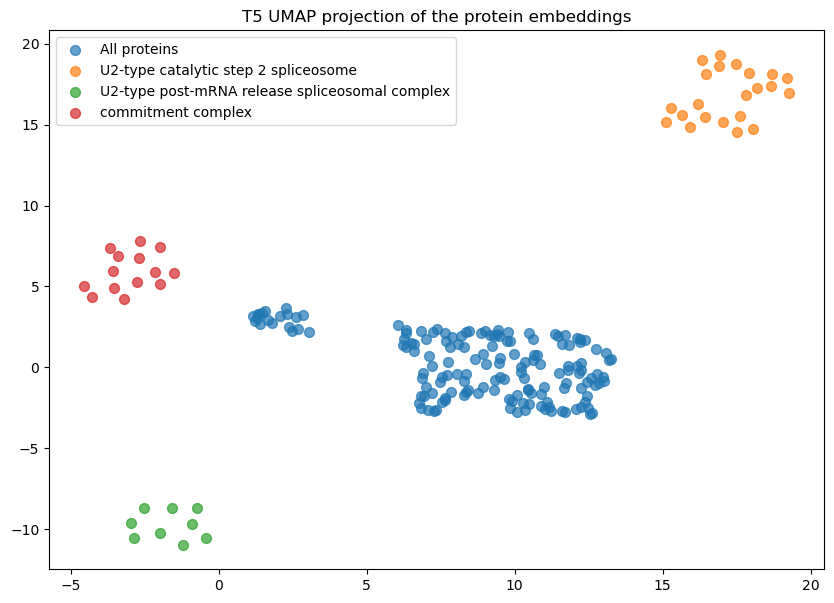

In [13]:
import umap
from sklearn.preprocessing import StandardScaler

# ... previous code goes here ...

# Combine embeddings and apply UMAP
all_embeddings = T5Embed_min
all_embeddings_scaled = StandardScaler().fit_transform(all_embeddings)
embedding_umap = umap.UMAP(n_neighbors=5, min_dist=0.3, random_state=1000).fit_transform(all_embeddings_scaled)

# Separate UMAP results for covid and flu
temp = train_terms_min[train_terms_min['term'] == "GO:0071007"]
column_values = temp['EntryID'].tolist()
new_temp = T5Embed_min.loc[T5Embed_min.index.isin(column_values)]
G6_embeddings_scaled = StandardScaler().fit_transform(new_temp)
GO0071006_umap = umap.UMAP(n_neighbors=5, min_dist=0.3, random_state=1000).fit_transform(G6_embeddings_scaled)

temp = train_terms_min[train_terms_min['term'] == "GO:0071008"]
column_values = temp['EntryID'].tolist()
new_temp = T5Embed_min.loc[T5Embed_min.index.isin(column_values)]
G6_embeddings_scaled = StandardScaler().fit_transform(new_temp)
GO0071008_umap = umap.UMAP(n_neighbors=5, min_dist=0.3, random_state=1000).fit_transform(G6_embeddings_scaled)


temp = train_terms_min[train_terms_min['term'] == "GO:0000243"]
column_values = temp['EntryID'].tolist()
new_temp = T5Embed_min.loc[T5Embed_min.index.isin(column_values)]
G6_embeddings_scaled = StandardScaler().fit_transform(new_temp)
GO0000243_umap = umap.UMAP(n_neighbors=5, min_dist=0.3, random_state=1000).fit_transform(G6_embeddings_scaled)


temp = train_terms_min[train_terms_min['term'] == "GO:0005684"]
column_values = temp['EntryID'].tolist()
new_temp = T5Embed_min.loc[T5Embed_min.index.isin(column_values)]
G6_embeddings_scaled = StandardScaler().fit_transform(new_temp)
GO0005684_umap = umap.UMAP(n_neighbors=5, min_dist=0.3, random_state=1000).fit_transform(G6_embeddings_scaled)


temp = train_terms_min[train_terms_min['term'] == "GO:0071006"]
column_values = temp['EntryID'].tolist()
new_temp = T5Embed_min.loc[T5Embed_min.index.isin(column_values)]
G6_embeddings_scaled = StandardScaler().fit_transform(new_temp)
GO0071006_umap = umap.UMAP(n_neighbors=5, min_dist=0.3, random_state=1000).fit_transform(G6_embeddings_scaled)


# Plotting
plt.figure(figsize=(10, 7))
plt.scatter(*embedding_umap.T, s=50, alpha=0.7, label="All proteins")
plt.scatter(*GO0071006_umap.T, s=50, alpha=0.7, label="U2-type catalytic step 2 spliceosome") 
plt.scatter(*GO0071008_umap.T, s=50, alpha=0.7, label="U2-type post-mRNA release spliceosomal complex") 
plt.scatter(*GO0000243_umap.T, s=50, alpha=0.7, label="commitment complex")
#plt.scatter(*GO0071006_umap.T, s=50, alpha=0.7, label="U1-type catalytic step 1 spliceosome")
#plt.scatter(*GO0005684_umap.T, s=50, alpha=0.7, label="GO0005684") 
plt.legend()
plt.title('T5 UMAP projection of the protein embeddings')
plt.show()

## ProtBert Embeddings



#### Loading Embeddings 


In [14]:
Ids = np.load("/kaggle/input/protbert-embeddings-for-cafa5/train_ids.npy")
arr = np.load("/kaggle/input/protbert-embeddings-for-cafa5/train_embeddings.npy")

# Convert the numpy array to a pandas DataFrame
T5Emb = pd.DataFrame(arr)
Ids = pd.Series(Ids.squeeze()) 
T5Emb.index = Ids

# Display the first 5 rows of the DataFrame
T5Emb.head()

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
P20536,0.155392,0.035353,0.089697,-0.250368,0.248972,-0.032696,-0.073959,0.011419,-0.064566,-0.149671,...,-0.031426,-0.067552,-0.070645,-0.108290,0.036037,-0.180188,-0.099818,-0.039517,-0.073583,0.045931
O73864,-0.072053,0.093417,-0.002659,-0.005690,0.113906,-0.010813,-0.101786,0.021196,-0.012389,-0.028101,...,0.064644,-0.020896,-0.120009,-0.104604,-0.033123,0.030718,0.002714,-0.019167,-0.022672,0.072778
O95231,0.143780,0.019153,0.086995,-0.215061,0.219807,-0.028687,-0.101207,0.031871,-0.043015,-0.121149,...,-0.037286,-0.064872,-0.082310,-0.189828,0.027312,-0.189434,-0.097486,-0.054416,-0.042178,0.059392
A0A0B4J1F4,-0.037358,0.007036,0.083136,-0.116788,-0.000758,-0.025243,-0.105427,0.070486,0.069643,-0.031957,...,0.103480,-0.023106,-0.105887,-0.105809,0.004708,-0.051759,-0.020586,-0.078935,-0.056303,0.011840
P54366,0.134157,0.035627,0.092638,-0.181336,0.196127,-0.028752,-0.089066,0.031362,-0.039287,-0.114085,...,-0.079311,-0.003805,-0.094771,-0.124049,-0.015014,-0.155916,-0.068633,-0.071746,-0.022954,0.034192


In [15]:
T5Embed_min = T5Emb.loc[T5Emb.index.isin(Prot)]
T5Embed_min

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
O75643,0.167438,0.123667,0.100122,-0.175419,0.257772,-0.061156,-0.093897,0.051994,0.000427,-0.086390,...,-0.175113,0.041615,-0.111548,-0.116751,-0.064562,-0.048033,-0.019442,-0.081386,-0.053673,-0.001997
Q09685,-0.005761,0.008364,0.047738,-0.088752,0.062935,0.064238,-0.081764,0.075983,-0.058635,-0.039992,...,0.002530,0.004327,-0.071424,-0.123883,-0.008475,-0.023390,-0.007385,-0.039651,0.047835,0.000582
Q03375,0.070873,0.018244,0.105091,-0.095490,0.138920,0.021042,-0.055531,0.035998,-0.050947,-0.079685,...,-0.085676,0.049068,-0.041709,-0.137083,-0.058634,-0.044858,-0.017251,-0.107848,-0.021389,-0.012742
Q2TAY7,0.126357,0.049114,0.079471,-0.141670,0.234623,-0.031717,-0.120548,0.003629,-0.066304,-0.137966,...,-0.212605,0.059666,-0.123917,-0.053785,-0.081314,-0.139319,-0.057699,-0.098872,-0.028364,-0.020698
P38919,0.152503,0.018181,0.103558,-0.207710,0.218461,-0.025693,-0.098472,0.038259,-0.046650,-0.123672,...,-0.054711,-0.050406,-0.095535,-0.168845,0.028962,-0.205516,-0.086605,-0.069121,-0.035756,0.049962
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q00539,0.122364,0.064692,0.078880,-0.149218,0.244198,-0.040541,-0.124362,0.013835,-0.023258,-0.138422,...,-0.181718,0.070210,-0.101827,-0.088004,-0.055498,-0.108891,-0.044890,-0.084715,0.006434,-0.013895
P40567,0.069169,0.009619,0.061068,-0.124726,0.032716,-0.021585,-0.113996,0.062200,-0.001549,-0.040794,...,-0.037798,0.029668,-0.093701,-0.111245,-0.071240,-0.057795,-0.012482,-0.047233,-0.011566,-0.003511
Q9Y4Y9,0.039089,0.007271,0.067128,-0.074276,0.093155,0.032843,-0.031517,0.079994,0.013642,-0.061155,...,0.075972,0.000529,-0.070733,-0.106957,0.021895,-0.055108,0.034568,-0.063919,-0.046438,0.083312
O94906,0.144692,0.047002,0.087800,-0.158156,0.224526,-0.035733,-0.118284,0.007366,-0.060664,-0.155314,...,-0.199109,0.028571,-0.124403,-0.044122,-0.045441,-0.172145,-0.071684,-0.100594,-0.024730,0.017917


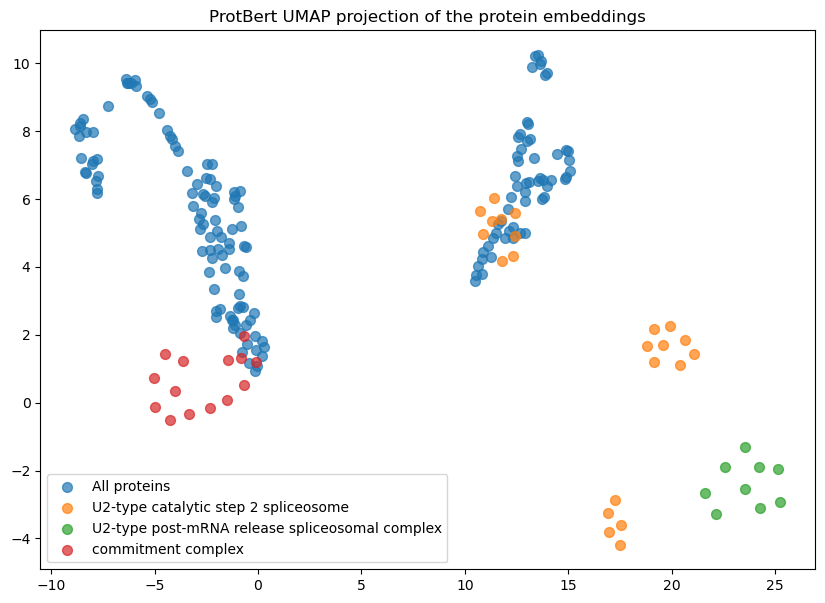

In [16]:
import umap
from sklearn.preprocessing import StandardScaler

# ... previous code goes here ...

# Combine embeddings and apply UMAP
all_embeddings = T5Embed_min
all_embeddings_scaled = StandardScaler().fit_transform(all_embeddings)
embedding_umap = umap.UMAP(n_neighbors=5, min_dist=0.3, random_state=1000).fit_transform(all_embeddings_scaled)

# Separate UMAP results for covid and flu
temp = train_terms_min[train_terms_min['term'] == "GO:0071007"]
column_values = temp['EntryID'].tolist()
new_temp = T5Embed_min.loc[T5Embed_min.index.isin(column_values)]
G6_embeddings_scaled = StandardScaler().fit_transform(new_temp)
GO0071006_umap = umap.UMAP(n_neighbors=5, min_dist=0.3, random_state=1000).fit_transform(G6_embeddings_scaled)

temp = train_terms_min[train_terms_min['term'] == "GO:0071008"]
column_values = temp['EntryID'].tolist()
new_temp = T5Embed_min.loc[T5Embed_min.index.isin(column_values)]
G6_embeddings_scaled = StandardScaler().fit_transform(new_temp)
GO0071008_umap = umap.UMAP(n_neighbors=5, min_dist=0.3, random_state=1000).fit_transform(G6_embeddings_scaled)


temp = train_terms_min[train_terms_min['term'] == "GO:0000243"]
column_values = temp['EntryID'].tolist()
new_temp = T5Embed_min.loc[T5Embed_min.index.isin(column_values)]
G6_embeddings_scaled = StandardScaler().fit_transform(new_temp)
GO0000243_umap = umap.UMAP(n_neighbors=5, min_dist=0.3, random_state=1000).fit_transform(G6_embeddings_scaled)


temp = train_terms_min[train_terms_min['term'] == "GO:0005684"]
column_values = temp['EntryID'].tolist()
new_temp = T5Embed_min.loc[T5Embed_min.index.isin(column_values)]
G6_embeddings_scaled = StandardScaler().fit_transform(new_temp)
GO0005684_umap = umap.UMAP(n_neighbors=5, min_dist=0.3, random_state=1000).fit_transform(G6_embeddings_scaled)


temp = train_terms_min[train_terms_min['term'] == "GO:0071006"]
column_values = temp['EntryID'].tolist()
new_temp = T5Embed_min.loc[T5Embed_min.index.isin(column_values)]
G6_embeddings_scaled = StandardScaler().fit_transform(new_temp)
GO0071006_umap = umap.UMAP(n_neighbors=5, min_dist=0.3, random_state=1000).fit_transform(G6_embeddings_scaled)


# Plotting
plt.figure(figsize=(10, 7))
plt.scatter(*embedding_umap.T, s=50, alpha=0.7, label="All proteins")
plt.scatter(*GO0071006_umap.T, s=50, alpha=0.7, label="U2-type catalytic step 2 spliceosome") 
plt.scatter(*GO0071008_umap.T, s=50, alpha=0.7, label="U2-type post-mRNA release spliceosomal complex") 
plt.scatter(*GO0000243_umap.T, s=50, alpha=0.7, label="commitment complex")
#plt.scatter(*GO0071006_umap.T, s=50, alpha=0.7, label="U1-type catalytic step 1 spliceosome")
#plt.scatter(*GO0005684_umap.T, s=50, alpha=0.7, label="GO0005684") 
plt.legend()
plt.title('ProtBert UMAP projection of the protein embeddings')
plt.show()